# Diamond price model development project

**Project objectives:**

1. develop a model that will predict the price of a diamond based on a set of characteristics
2. deploy the trained model with tensorflow serving
3. develop a simple web interface using streamlit to make online predictions of a diamond price
4. develop pipeline that will automatically train a model and deploy it in production 

### Intoduction

This project uses a dataset of 

This notebook goes through diamond price prediction model development. The model is developed in tensorflow 2. 

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys

from sklearn.model_selection import train_test_split 

print(tf.__version__)

2.8.0


In [3]:
print(tf.keras.__version__)

2.8.0


In [ ]:
##install any other required libraries 
##gcsfs - gs for pandas

!pip install --user gcsfs

In [75]:
##save some variables

PROJECT_ID='diamonds-341821'
DATA_BUCKET ='gs://diamonds_data/diamonds.csv'
MODEL_STORAGE = os.path.join("gs://", 'stored_model', 'stored_model', 'v1')

In [72]:
print(MODEL_STORAGE)

gs://saved_model\saved_model\v1


In [2]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [37]:
##authenticate to google cloud
## if we run this in AI platform notebooks - already authenticated
## if we run this in google colab, we will authenticate through google account
## if this notebook runs outside of google environemnt, use service account 

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
       ##%env GOOGLE_APPLICATION_CREDENTIALS='C:\\Users\Milan Jendrisek\\projects\\diamonds\\key\\diamonds-341821-f3138746b45c.json'
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'key\\diamonds-341821-f3138746b45c.json'

In [38]:
from google.cloud import storage
client = storage.Client()

In [47]:
##load diamond data from GS
df = pd.read_csv(DATA_BUCKET)

In [48]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [49]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [160]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [52]:
##split the dataframe to train and test
y = df.pop('price')
X = df

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(X,y, test_size=0.20,random_state=42)

display(X.head())
display(y.head())

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.7+ MB


In [53]:
print('the size of the training set: x:{}, y:{}'.format(len(df_train_X), len(df_train_y)))
print('the size o the validation set: x:{}, y:{}'.format(len(df_test_X), len(df_test_y)))

the size of the training set: x:43152, y:43152
the size o the validation set: x:10788, y:10788


Plan of action:

    1. convert dataframe to dataset - use dict() to wrap a pandas dataframe with different tpes 
         
    2. remap the dataset to set a label - this has been replaced with 1. splitting data to features and label df, and passing it to from_tensor_slices function
    3. data preprocessing
        - convert categorical  variables 
        - normalize numeric features
        
    4. build a model 

In [55]:
##create a dataset from a dataframe  - this is so you can do preprocessing directly in a model

##using tf.data.Datasets.from_tensor_slices()

train_ds = tf.data.Dataset.from_tensor_slices((dict(df_train_X),df_train_y))
test_ds = tf.data.Dataset.from_tensor_slices((dict(df_test_X), df_test_y))


In [56]:
##you need to patch the datasest here


train_ds = train_ds.batch(32)
test_ds = test_ds.batch(32)

In [57]:
train_ds.take(1)

<TakeDataset element_spec=({'carat': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'cut': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'color': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'clarity': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'depth': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'table': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'x': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'y': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'z': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
##code to produce names and types of the columns 

columns = list(df_train_X.columns)

for column in columns:
    print('name:', column)
    print('type: ',df_train_X[column].dtype)

In [59]:
##create a list of feature names, separate them by type

NUMERIC_FEATURES = ['carat','depth','table','x','y','z']
CATEGORICAL_FEATURES = ['cut','color','clarity']

In [234]:
##create inputs 
    ## it is a dictionary if inputs - from numeric and categorical ones 

##all_inputs = {column: tf.keras.Input(shape=(1,),name=column, dtype=tf.float64) for column in NUMERIC_FEATURES}
##all_inputs.update({column: tf.keras.Input(shape=(1,),name=column, dtype=tf.string) for column in CATEGORICAL_FEATURES})

##using for loop to create inputs


In [228]:
all_inputs

{'carat': <tf.Tensor 'carat_9:0' shape=(None, 1) dtype=float64>,
 'depth': <tf.Tensor 'depth_9:0' shape=(None, 1) dtype=float64>,
 'table': <tf.Tensor 'table_9:0' shape=(None, 1) dtype=float64>,
 'x': <tf.Tensor 'x_9:0' shape=(None, 1) dtype=float64>,
 'y': <tf.Tensor 'y_9:0' shape=(None, 1) dtype=float64>,
 'z': <tf.Tensor 'z_9:0' shape=(None, 1) dtype=float64>,
 'cut': <tf.Tensor 'cut_6:0' shape=(None, 1) dtype=string>,
 'color': <tf.Tensor 'color_6:0' shape=(None, 1) dtype=string>,
 'clarity': <tf.Tensor 'clarity_6:0' shape=(None, 1) dtype=string>}

In [61]:
##preprocessing functions

##for numerical features and categorical features 

def get_preprocessing_layer(dataset, feature):
    
    ##prepare dataset with one feature only
    ds_feature = dataset.map(lambda x,y: x[feature])
    ##ds_feature = ds_feature.map(lambda x: tf.expand_dims(x,-1))
    
    #print("feature sample for:", feature)
    #print(ds_feature.take(1))
    
    if feature in NUMERIC_FEATURES:
        print("the feature {} is of type numeric".format(feature))
        
        normalizer = tf.keras.layers.Normalization(axis=None)
        
    elif feature in CATEGORICAL_FEATURES: 
        print("the feature {} is of type categorical".format(feature))

        normalizer = tf.keras.layers.StringLookup(output_mode='multi_hot')
    
    ##fit a normalizer to the training set
    normalizer.adapt(ds_feature)
    
    ##if feature in CATEGORICAL_FEATURES:
      ##  encoder = tf.keras.layers.CategoryEncoding(num_tokens=normalizer.vocabulary_size())
        ##encoder.adapt(normalizer(ds_feature).numpy())
        
        #encoder.adapt(normalizer(df_train_X[feature]))
        #print("encoder")
       ## print(encoder)
        ##return encoder
     ##   return lambda feature: encoder(normalizer(feature))
    
    ##print(normalizer)
    return normalizer
    

In [62]:
##create preprocessing layer
    ##format: 

#preprocessed_features = [get_preprocessing_layer(train_ds, feature, input_) for feature, input_ in all_inputs.items()]
##preprocessed_features.append([get_preprocessing_layer(train_ds, feature) for feature in CATEGORICAL_FEATURES])

##doing it through a for loop rather than list comprehension

all_inputs = {}
preprocessed_features = []


for feature_name in NUMERIC_FEATURES+CATEGORICAL_FEATURES:
        
        if feature_name in NUMERIC_FEATURES:
            #create input
            feature_input = tf.keras.Input(shape=(1,),name=feature_name)
            ##print('feature_input: ', feature_input)
            
        elif feature_name in CATEGORICAL_FEATURES:
            feature_input = tf.keras.Input(shape=(1,),name=feature_name,dtype=tf.string)
            ##print('feature_input: ', feature_input)
        
        all_inputs[feature_name] = feature_input
        #create transformed feature
        preprocessing_layer = get_preprocessing_layer(train_ds,feature_name)
        #save it in the list
        with_input = preprocessing_layer(feature_input)
        preprocessed_features.append(with_input)
        

#see what you created
print(all_inputs)
print(preprocessed_features)


feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='carat'), name='carat', description="created by layer 'carat'")
the feature carat is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='depth'), name='depth', description="created by layer 'depth'")
the feature depth is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='table'), name='table', description="created by layer 'table'")
the feature table is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='x'), name='x', description="created by layer 'x'")
the feature x is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='y'), name='y', description="created by layer 'y'")
the feature y is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32

In [63]:
##testing the preprocessing layer only!!

##create a model that does preprocessing only!!
preprocessing = tf.keras.Model(all_inputs, preprocessed_features)

In [64]:
preprocessing.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 carat (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 depth (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 table (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 x (InputLayer)                 [(None, 1)]          0           []                               
                                                                                              

In [65]:
##create a simple model
preprocessed_layers = tf.keras.layers.concatenate(preprocessed_features)
x = tf.keras.layers.Dense(20, activation='relu')(preprocessed_layers)
x = tf.keras.layers.Dense(10, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

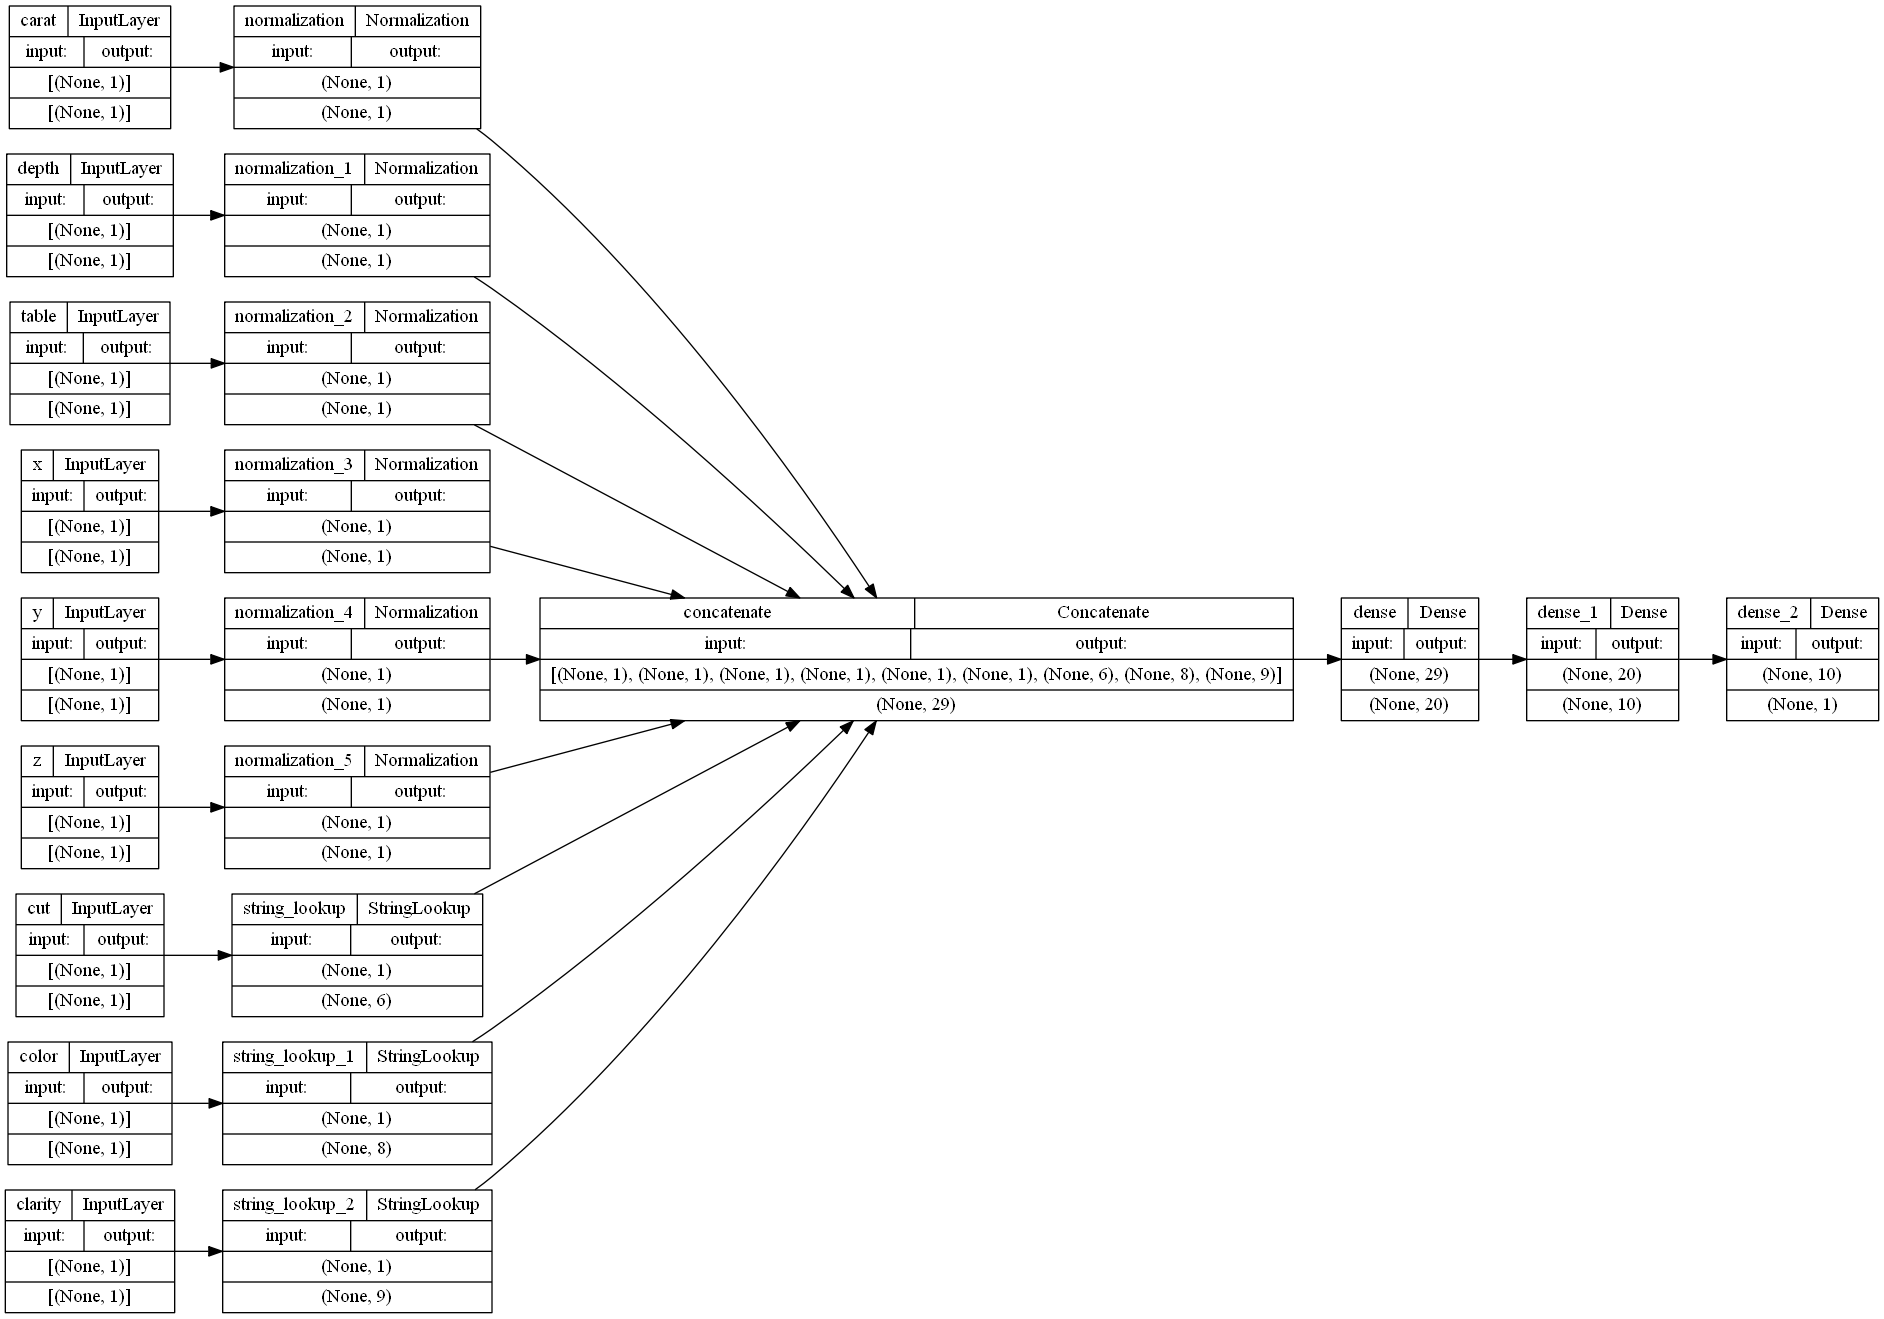

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True,rankdir="LR")

In [68]:
##compile the model


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [69]:
##fit the model

LOGS = 'tb-logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard() ##this will create a default log directory for logs 

history = model.fit(train_ds, epochs=10, validation_data=test_ds,
         callbacks=[tensorboard_callback])

Epoch 1/10
1349/1349 [==============================] - 3s 2ms/step - loss: 3407298.0000 - root_mean_squared_error: 1845.8867 - val_loss: 838829.8125 - val_root_mean_squared_error: 915.8765
Epoch 2/10
1349/1349 [==============================] - 2s 1ms/step - loss: 918252.8125 - root_mean_squared_error: 958.2551 - val_loss: 668270.1250 - val_root_mean_squared_error: 817.4779
Epoch 3/10
1349/1349 [==============================] - 2s 1ms/step - loss: 735209.4375 - root_mean_squared_error: 857.4435 - val_loss: 565924.6875 - val_root_mean_squared_error: 752.2797
Epoch 4/10
1349/1349 [==============================] - 2s 2ms/step - loss: 627959.1875 - root_mean_squared_error: 792.4388 - val_loss: 515939.6250 - val_root_mean_squared_error: 718.2894
Epoch 5/10
1349/1349 [==============================] - 2s 2ms/step - loss: 564757.0000 - root_mean_squared_error: 751.5032 - val_loss: 488678.7500 - val_root_mean_squared_error: 699.0556
Epoch 6/10
1349/1349 [==============================] - 2s

In [157]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11172), started 0:10:56 ago. (Use '!kill 11172' to kill it.)

In [151]:
!tensorboard dev upload --logdir 'C:/Users/Milan Jendrisek/projects/diamonds/logs'

2022-02-24 16:42:51.837683: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2022-02-24 16:42:51.837714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: Jendrisek/projects/diamonds/logs'


In [176]:
dict(df.loc[9])

{'carat': 0.23,
 'cut': 'Very Good',
 'color': 'H',
 'clarity': 'VS1',
 'depth': 59.4,
 'table': 61.0,
 'price': 338,
 'x': 4.0,
 'y': 4.05,
 'z': 2.39}

In [186]:
df['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [332]:
##RANDOM TESTING
##unpacking a list

x,y = ['x','y']

print(x)
print(y)

x
y


In [355]:
##make predictions

##create a sample
sample = [{'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]}]

samples = [{'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]},
 {'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]} ]

sample_list = [[0.6],
 ['Ideal'],
 ['H'],
 ['VS1'],
 [59.4],
 [61.0],
 [4.0],
 [4.05],
 [2.39]]

##pass it to a model

print(np.array(sample_list))

##dictionary

##list of dictionaries

##input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

#1. unpack the list
#2. unpack the dictionary

model_test = [{name: tf.convert_to_tensor([value]) for name, value in example.items()} for example in sample]

print(model_test)

##input_dict = {name: tf.convert_to_tensor([item.value])for item.items() in items for items in sample}

##model.predict_on_batch(model_test)

model(model_test)


[['0.6']
 ['Ideal']
 ['H']
 ['VS1']
 ['59.4']
 ['61.0']
 ['4.0']
 ['4.05']
 ['2.39']]
[{'carat': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6]], dtype=float32)>, 'cut': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'Ideal']], dtype=object)>, 'color': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'H']], dtype=object)>, 'clarity': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'VS1']], dtype=object)>, 'depth': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[59.4]], dtype=float32)>, 'table': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[61.]], dtype=float32)>, 'x': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.]], dtype=float32)>, 'y': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.05]], dtype=float32)>, 'z': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.39]], dtype=float32)>}]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1179.7206]], dtype=float32)>

In [ ]:
##only works from linux environment 
## tested from google colab

model.save(MODEL_STORAGE)

In [ ]:
##storing a model on GS seems to only work from non windows machines
##worked correctly from google colab 
## need to implement a check if we are on a windows machine jupyter notebook

tf.saved_model.save(model,MODEL_STORAGE)

In [282]:
##testing of the model from tensorflow/serving on gcp 
import json
import http

import requests 

#from requests import Session


def rest_request(text, url=None):
    
    if url is None:
        url='https://diamonds-image-bfpumxj2xa-uc.a.run.app/v1/models/diamonds:predict'
        payload = json.dumps({"instances":text})
        print(payload)
        response = requests.post(url,data=payload)
        
        return response

In [353]:
rs = rest_request(samples)
print(rs.json())

{"instances": [{"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}, {"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}]}
{'predictions': [[1179.72058], [1179.72058]]}


In [362]:
rs = rest_request(sample)
print(type(rs.json()['predictions'][0][0]))

{"instances": [{"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}]}
<class 'float'>


In [234]:
json.dumps({'instances':{'carat': 0.6,
 'cut': 'Ideal',
 'color': 'H',
 'clarity': 'VS1',
 'depth': 59.4,
 'table': 61.0,
 'x': 4.0,
 'y': 4.05,
 'z': 2.39}})

'{"instances": {"carat": 0.6, "cut": "Ideal", "color": "H", "clarity": "VS1", "depth": 59.4, "table": 61.0, "x": 4.0, "y": 4.05, "z": 2.39}}'

In [ ]:
r = requests.post(url="http://localhost:9000/v1/models/multisensory:predict", data=json.dumps(data))

In [240]:
!curl -X POST https://diamonds-image-bfpumxj2xa-uc.a.run.app/v1/models/diamonds:predict -d '{"signature_name":"serving_default","examples": [{"carat": 0.6, "cut": "Ideal", "color": "H", "clarity": "VS1", "depth": 59.4, "table": 61.0, "x": 4.0, "y": 4.05, "z": 2.39}]}'

{

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   106  100    64  100    42    267    175 --:--:-- --:--:-- --:--:--   445
curl: (3) bad range specification in URL position 2:
[{carat:
 ^



    "error": "JSON Parse error: Invalid value. at offset: 0"
}
